# Audio Analysis

In [21]:
# link backend
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('/home/darkangel/ai-light-show/backend')
from backend.config import SONGS_TEMP_DIR, SONGS_DIR

# sample song 
song_name = 'born_slippy'
songs_folder = "/home/darkangel/ai-light-show/songs/"
song_file = f"{songs_folder}{song_name}.mp3"
print(f"song: {song_name} | {song_file}")

# load metadata
from backend.models.song_metadata import SongMetadata
song = SongMetadata(song_name=song_name, songs_folder=songs_folder)
print(f"song metadata: {song}")

# load clusters timeline
clusters_timeline = []
if song.patterns is not None:
    for p in song.patterns:
        if p['stem']=='drums' and 'clusters' in p:
            clusters_timeline = p['clusters']
            break
print(f"clusters_timeline: {len(clusters_timeline)}")  


song: born_slippy | /home/darkangel/ai-light-show/songs/born_slippy.mp3
song metadata: SongMetadata(song_name=born_slippy, title=born slippy, genre=unknown, bpm=139.99, duration=135.7786865234375, beats=325, arrangement=10)
clusters_timeline: 323


## Extract Stems

In [2]:
from backend.ai.demucs_split import extract_stems
stems_folder = extract_stems(song_file)

drums_path = f"{stems_folder['output_folder']}/drums.wav"

🎵 Extracting stems from the song...


Noise gate?

In [4]:
from backend.ai.audio_proccess import noise_gate
noise_gate(input_path=drums_path, threshold_db=-35.0)

  Noise gate | min -35.0 dB to /home/darkangel/ai-light-show/songs/temp/htdemucs/born_slippy/drums.wav...


'/home/darkangel/ai-light-show/songs/temp/htdemucs/born_slippy/drums.wav'

In [10]:
drums_path = '/home/darkangel/ai-light-show/songs/temp/htdemucs/born_slippy/drums.wav'

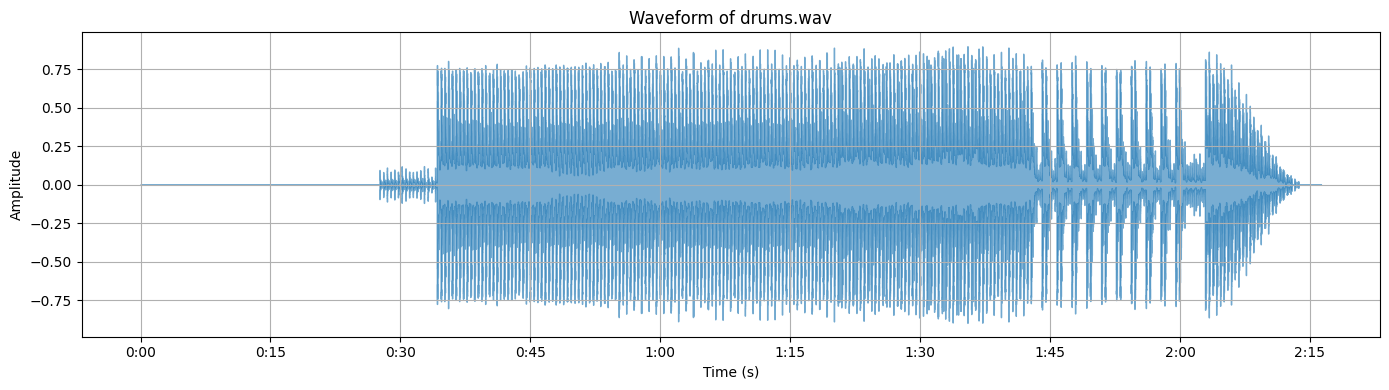

In [11]:
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

# 🔍 Plot waveform
plt.figure(figsize=(14, 4))
y, sr = librosa.load(drums_path, sr=16000, mono=True)
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of drums.wav")
plt.xlabel("Time (s)")

num_points = len(y)
times = np.linspace(0, num_points / sr, num_points)
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

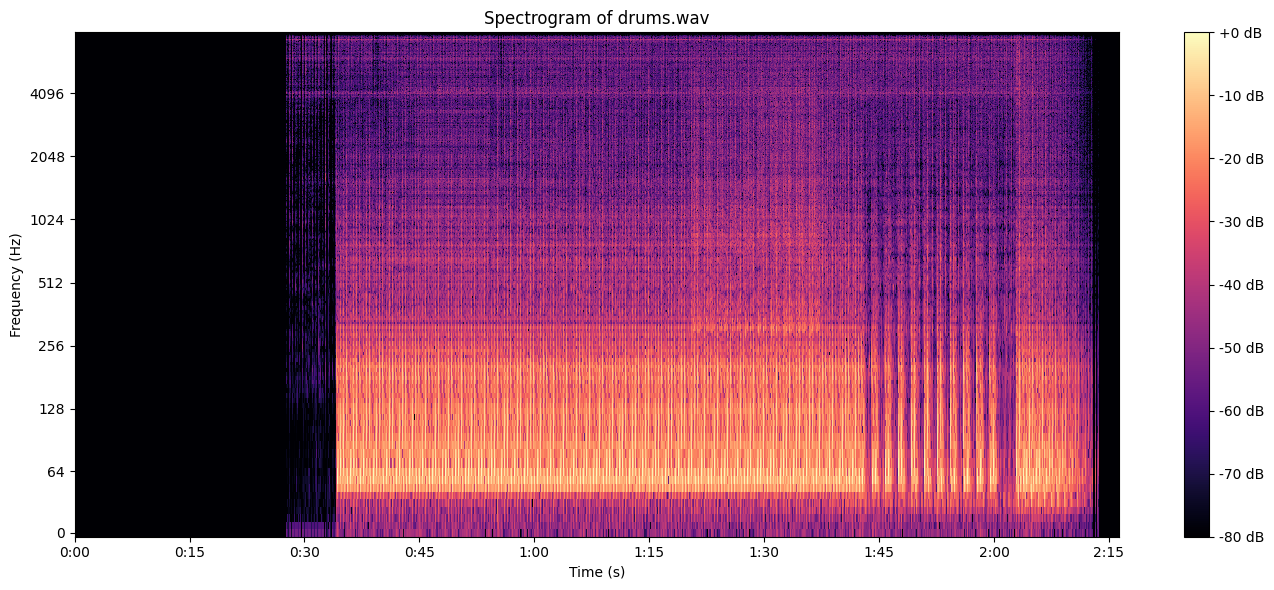

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# Plot spectrogram
S = librosa.stft(y, n_fft=4096, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(40, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of drums.wav')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

## Pattern Finder

In [ ]:
from backend.ai.pattern_finder import get_stem_clusters
found_clusters = get_stem_clusters(song.get_beats_array(), drums_path, debug=True)
clusters_timeline = found_clusters['clusters_timeline']


⎱ Segment duration: 0.5 beats
⚠️ All segments were silent for 0.5 beats — skipping...

⎱ Segment duration: 1 beats
   → Clusters: 14
   → Segments: 324
   → Score: 0.0432
Similarity Matrix (%):
     C0  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13
  C0   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
  C1   0.0  100.0  100.0  100.0   93.7   92.1   98.0  100.0   99.7   93.8   99.0   97.0   91.8   99.0
  C2   0.0  100.0  100.0  100.0   93.6   92.0   97.9  100.0   99.7   93.7   98.9   96.9   91.7   98.9
  C3   0.0  100.0  100.0  100.0   93.4   91.7   97.9  100.0   99.9   93.5   99.0   96.9   91.4   98.9
  C4   0.0   93.7   93.6   93.4  100.0   99.3   98.0   93.4   92.5   99.9   95.5   98.0   99.5   96.3
  C5   0.0   92.1   92.0   91.7   99.3  100.0   96.3   91.7   90.6   99.6   95.2   97.1   99.9   95.4
  C6   0.0   98.0   97.9   97.9   98.0   96.3  100.0   97.9   97.4   97.8   97.9   99.4   96.2   99.2
  C7   0.0  100.0  100.0  1

In [22]:
for c in clusters_timeline[:20]:
    print(f"{c['start']:.2f} - {c['end']:.2f} > {c['cluster']}")

0.37 - 27.54 > 3
0.79 - 1.63 > 3
1.21 - 2.04 > 3
1.63 - 2.46 > 3
2.04 - 2.88 > 3
2.46 - 3.30 > 3
2.88 - 3.71 > 3
3.30 - 4.13 > 3
3.71 - 4.55 > 3
4.13 - 4.97 > 3
4.55 - 5.39 > 3
4.97 - 5.80 > 3
5.39 - 6.22 > 3
5.80 - 6.64 > 3
6.22 - 7.06 > 3
6.64 - 7.48 > 3
7.06 - 7.89 > 3
7.48 - 8.31 > 3
7.89 - 8.73 > 3
8.31 - 9.15 > 3


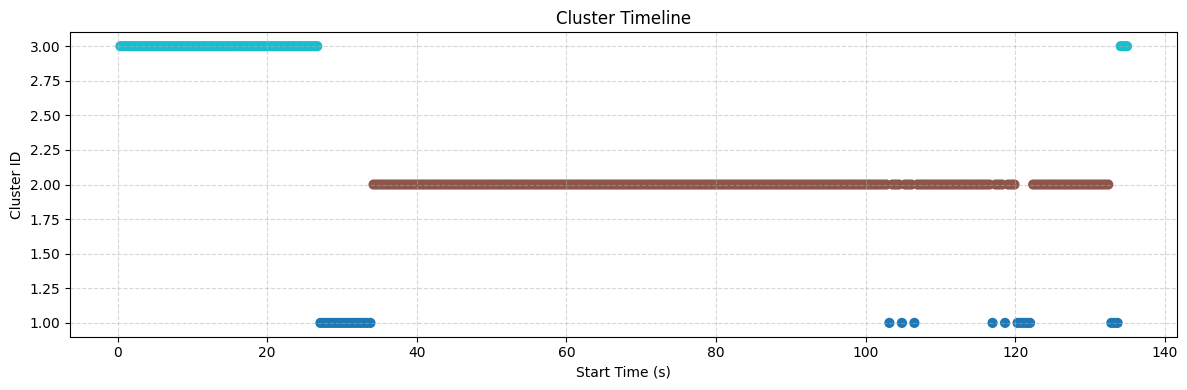

In [23]:
import matplotlib.pyplot as plt

# Extract start times and cluster ids
starts = [item['start'] for item in clusters_timeline]
clusters = [item['cluster'] for item in clusters_timeline]

plt.figure(figsize=(12, 4))
plt.scatter(starts, clusters, c=clusters, cmap='tab10', s=40)
plt.xlabel("Start Time (s)")
plt.ylabel("Cluster ID")
plt.title("Cluster Timeline")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()